# Reset

In [1]:
%reset -f

# Import

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import datetime
from PIL import Image

# Image loading and preprocessing

In [3]:
# convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Values of ImageNet
    
])

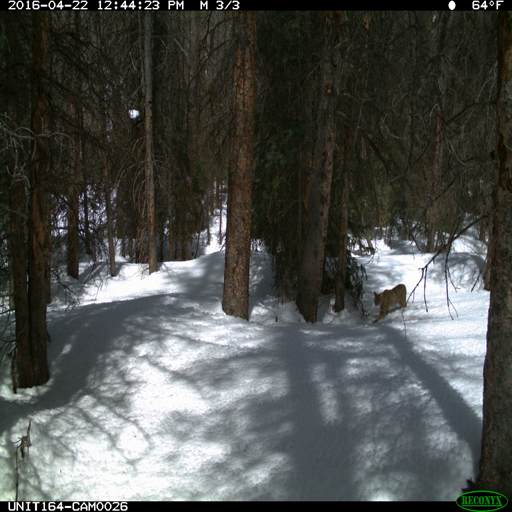

In [4]:
# Example image
img = Image.open('/exchange/dspro01/group3/data/train/bobcat/2015_Unit164_Ivan026_img0171.jpg')
img_small = img.resize((512, 512))
img_small

In [5]:
img_transformed = transform(img)

def denormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

to_pil = transforms.ToPILImage()

denormalized_image = to_pil(denormalize(img_transformed.clone()))


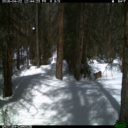

In [6]:
denormalized_image


In [7]:
# For reproducibility of Transformation
seed = 42
torch.manual_seed(seed)

In [8]:
data_dir = '/exchange/dspro01/group3/data/train' 
# dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name
# Normalization independent of dataset so applied at root

In [9]:
num_classes = 12  # number of categories
num_epochs =  25  
learning_rate = 0.001 
batch_size = 32

In [10]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


## Split data

In [11]:
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

In [12]:
len(train_dataset) == (2400 * 12 * 0.8) # Safety check

True

## Load data

In [13]:
# Divides into batches, shuffles data, load in parallel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [14]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}


In [15]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Model loading and transfer learning

In [16]:
from torchvision import models
import torch.nn as nn

## Load model

# Training & Validation loop

In [17]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import datetime
from torchvision import models

model = models.resnet50(pretrained=True)

input_features = model.fc.in_features
hidden_dim1 = 512
hidden_dim2 = 256

model.fc = nn.Sequential(
    nn.Linear(input_features, hidden_dim1),  # First layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(hidden_dim1, hidden_dim2),    # Second layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(hidden_dim2, num_classes)     # Classification layer
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_labels, val_predictions = [], []
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_val_accuracy = 0.0
best_model_path = f'best_model_{current_time}.pth'
val_f1_scores, val_conf_matrices = [], []

patience, early_stopping_counter, best_epoch = 5, 0, 0

# Train
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss, running_corrects = 0.0, 0
        all_preds, all_labels = [], []

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())
            val_labels.append(all_labels)
            val_predictions.append(all_preds)

            f1 = f1_score(all_labels, all_preds, average='weighted')
            val_f1_scores.append(f1)
            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_epoch = epoch + 1
                early_stopping_counter = 0
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'accuracy': best_val_accuracy,
                }, best_model_path)
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1

    scheduler.step()

    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        print(f'Best validation accuracy achieved at epoch {best_epoch}: {best_val_accuracy:.4f}')
        break

print('Training complete')


Epoch 1/25
----------
train Loss: 1.6706 Acc: 0.3637
val Loss: 1.4563 Acc: 0.4259
Saved best model at epoch 1 with validation accuracy: 0.4259
Epoch 2/25
----------
train Loss: 1.4299 Acc: 0.4312
val Loss: 1.3504 Acc: 0.4722
Saved best model at epoch 2 with validation accuracy: 0.4722
Epoch 3/25
----------
train Loss: 1.3176 Acc: 0.4793
val Loss: 1.3675 Acc: 0.4898
Saved best model at epoch 3 with validation accuracy: 0.4898
Epoch 4/25
----------
train Loss: 1.1632 Acc: 0.5578
val Loss: 1.5881 Acc: 0.4429
Epoch 5/25
----------
train Loss: 1.0423 Acc: 0.6019
val Loss: 1.0238 Acc: 0.6016
Saved best model at epoch 5 with validation accuracy: 0.6016
Epoch 6/25
----------
train Loss: 0.8190 Acc: 0.6854
val Loss: 0.7406 Acc: 0.7247
Saved best model at epoch 6 with validation accuracy: 0.7247
Epoch 7/25
----------
train Loss: 0.7283 Acc: 0.7181
val Loss: 0.7004 Acc: 0.7363
Saved best model at epoch 7 with validation accuracy: 0.7363
Epoch 8/25
----------
train Loss: 0.6786 Acc: 0.7460
val Los

### Save values

In [19]:
import pandas as pd

data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_conf_matrix": val_conf_matrices,
    "val_labels": val_labels, #
    "val_predictions": val_predictions #
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_{current_time}.csv"
df.to_csv(file_name, index=False)


# Visualization of training results

In [20]:
len(train_losses)

21

Best validation accuracy: 0.7851 (Epoch 16)
Final accuracy gap (train - val): 0.0589


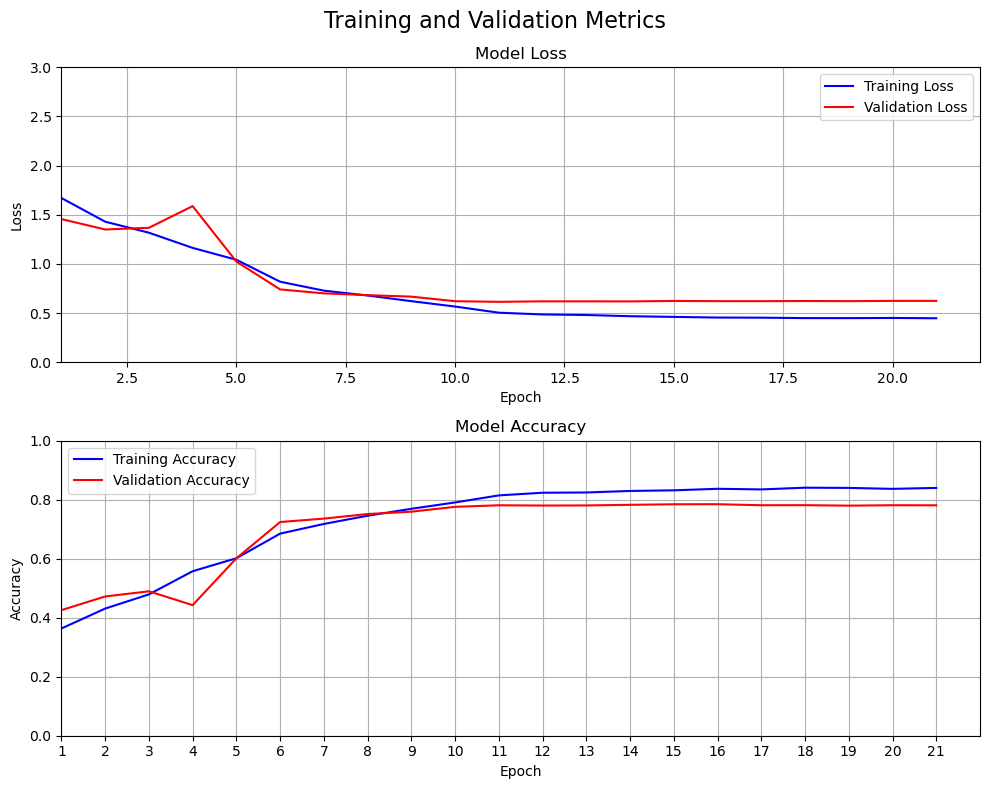

In [21]:
import matplotlib.pyplot as plt
import numpy as np

stopped_epoch = best_epoch + patience

# Data from your training output
epochs = range(1, stopped_epoch+1) ## stopped_epoch
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()


# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(1)
ax2.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1)) # HARD CODED, epochs
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
fig.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


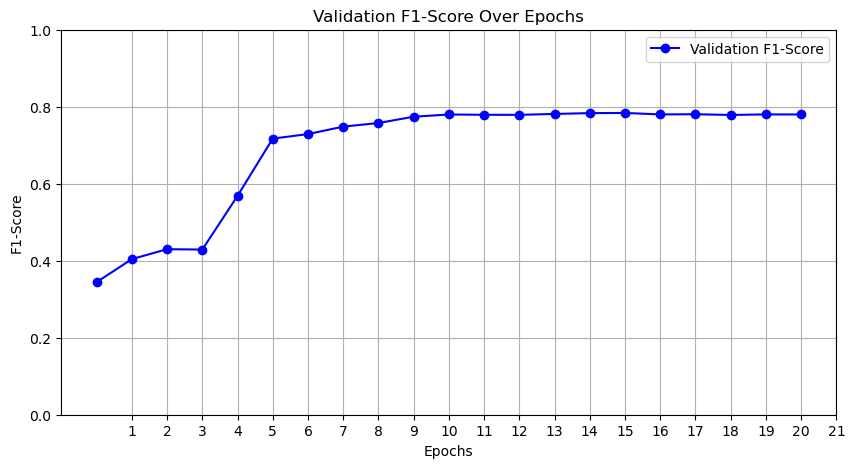

In [22]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1))
ax.legend()
ax.grid()
f.show()

16


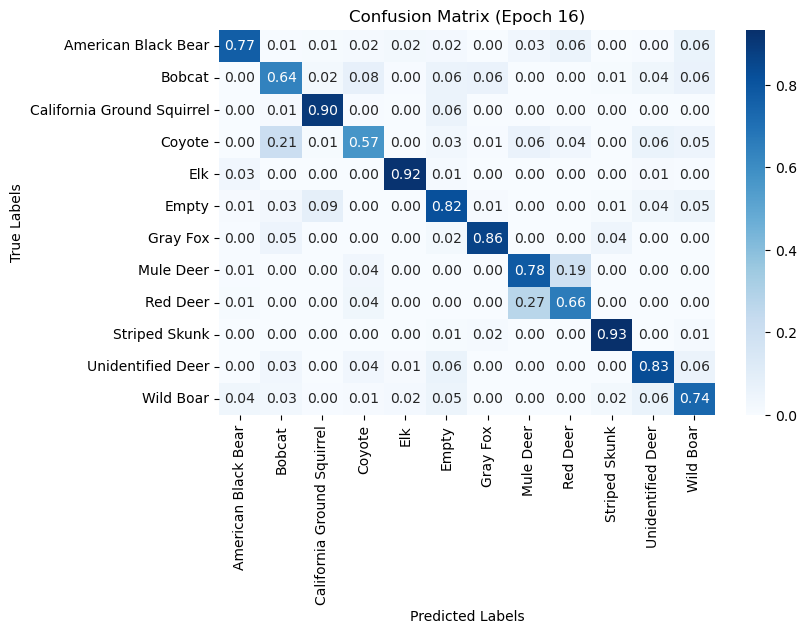

In [30]:
import seaborn as sns
print(best_epoch)
# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch
class_names = sorted(['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar'])

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(val_dataset)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()


Test set contains 600 pictures per category

In [27]:
test_dataset = datasets.ImageFolder(root='/exchange/dspro01/group3/data/test', transform=transform) # same transform as train and validation phases
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Load subset of test images for debugging

In [28]:
from torch.utils.data import Subset

# Create a subset of the first x images
subset_indices = list(range(50))
test_subset = Subset(test_dataset, subset_indices)

# Create a DataLoader for the subset
test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


## Load trained model and Resnet model

In [29]:
import torch
import torchvision.models as models
import torch.nn as nn
best_model_only = f'only_{best_model_path}'
# Load the pre-trained ResNet model
model = models.resnet50(pretrained=False)

# Modify the 'fc' layer to have 12 output classes
model.fc = nn.Linear(model.fc.in_features, 12)

model.load_state_dict(torch.load(best_model_only, map_location=torch.device('cpu')))
model.eval()


FileNotFoundError: [Errno 2] No such file or directory: 'only_best_model_2025-01-08_08-10-49.pth'

In [ ]:
class_names = sorted(['American Black Bear', 'California Ground Squirrel', 
               'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 
               'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 
               'Striped Skunk', 'Wild Boar'])
class_mapping = {i: class_names[i] for i in range(12)}

## Model on one picture of the test set

In [28]:
image_path = '/exchange/dspro01/group3/data/test/bobcat/2015_Unit097_Ivan076_img0742.jpg'
#image_path = '/exchange/dspro01/group3/data/test/gray fox/CA-01_08_13_2015_CA-01_0001873.jpg' #2nd example
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image).unsqueeze(0) # Add batch dimension

In [32]:
# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(input_tensor)  # Forward pass
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {predicted_class}")
print(f"Predicted class name: {class_mapping[predicted_class]}")


Predicted class: 3
Predicted class name: Gray Fox


## Model on all test set

In [40]:
all_labels = []
all_predictions = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        print('Loop start')
        outputs = model(inputs)  
        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())  
        print('label and prediction added to the lists')
    print('Testing done.')

Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and prediction added to the lists
Loop start
Prediction calculated
label and predicti

## Save test data as csv

In [65]:
import numpy as np
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
accuracy = np.mean(all_labels == all_predictions)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

#Plot precision for some images
for i in range(3):
    print(f"True label: {class_mapping[all_labels[i*600]]}, Predicted: {class_mapping[all_predictions[i*600]]}")


Accuracy on the test set: 83.81%
True label: American Black Bear, Predicted: American Black Bear
True label: California Ground Squirrel, Predicted: Gray Fox
True label: Elk, Predicted: Elk


## Plot data

True


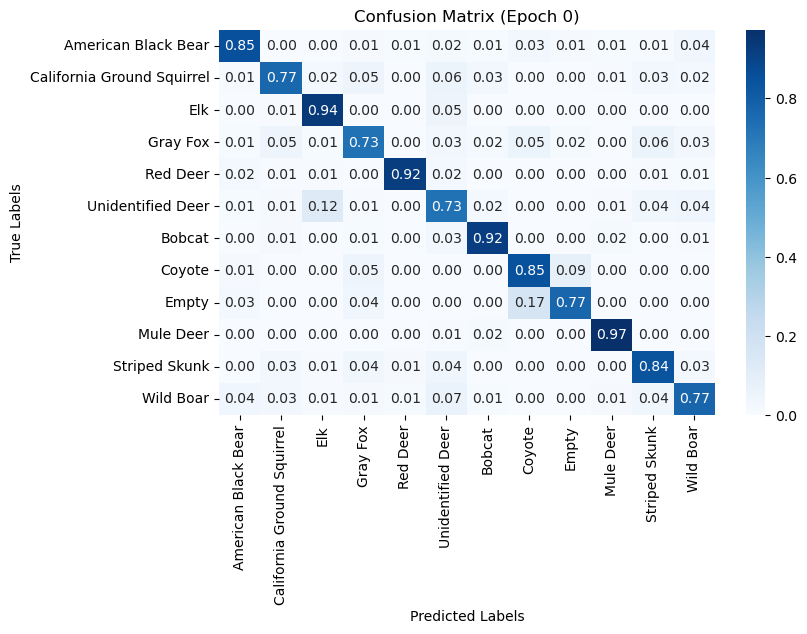

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
# Safety check
print(len(all_labels) == len(all_predictions))
# Confusion Matrix for the Test set
conf_matrix = confusion_matrix(all_labels, all_predictions)  # Index corresponds to the best epoch
class_names = ['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar']  # TODO CLASSES NAMES

f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix/ (len(all_labels)/num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()

In [60]:
# Create a DataFrame
import pandas as pd
df = pd.DataFrame({
    'Label': all_labels,
    'Prediction': all_predictions
})

# Save the DataFrame to a CSV file
filename = f'predictions_model_{best_model_only[-23:-4]}.csv'
df.to_csv(filename, index=False)